In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy import stats

# 1. 數據獲取與對齊 (Data Alignment)
# 技巧：一次下載多個 Ticker，Pandas 會自動幫你對齊 Index (日期)
tickers = ["SPY", "TSM"]
data = yf.download(tickers, start="2023-01-01", end="2025-01-01", progress=False)['Close']

# 計算報酬率並去除空值
#這一步非常關鍵：dropna() 會同時刪掉「任一」資產缺失的那一天，確保每一列的 TSM 和 SPY 都是同一天的數據。
returns = data.pct_change().dropna()

# 嚴格檢查：確保我們知道誰是誰
print("數據預覽:\n", returns.head())
y_tsm = returns['TSM'].values # Target
x_spy = returns['SPY'].values # Feature

# 2. 矩陣構造 (Numpy Stage)
N = len(y_tsm)
ones_vec = np.ones(N)

# 注意：這裡使用 flatten() 確保它們變成一維向量 (N,)，避免維度傳染問題
x_spy = x_spy.flatten()
y_tsm = y_tsm.flatten()

# 構造 Design Matrix X
X = np.column_stack((ones_vec, x_spy))

print(f"X shape: {X.shape}") # 應該是 (N, 2)
print(f"y shape: {y_tsm.shape}") # 應該是 (N,)

# 3. 求解 Normal Equation
# theta = (X^T X)^-1 X^T y
XtX = X.T @ X
Xty = X.T @ y_tsm

# 使用 solve 解線性方程
theta = np.linalg.solve(XtX, Xty)

# 4. 結果提取
# 這裡 theta 是一個一維陣列 [alpha, beta]，直接取值即可，不需要 .item() (除非維度又亂了)
alpha_manual = theta[0]
beta_manual = theta[1]

print(f"--- 手算結果 ---")
print(f"Alpha (超額報酬): {alpha_manual:.6f}")
print(f"Beta (市場敏感度): {beta_manual:.6f}")

# 5. Scipy 驗證
res = stats.linregress(x_spy, y_tsm)

print(f"\n--- Scipy 驗證 ---")
print(f"Alpha: {res.intercept:.6f}")
print(f"Beta:  {res.slope:.6f}")

# 6. 誤差檢查
# 使用 .item() 確保我們是在比較純量
diff_alpha = abs(alpha_manual - res.intercept)
diff_beta = abs(beta_manual - res.slope)

if diff_alpha < 1e-10 and diff_beta < 1e-10:
    print("\n✅ 驗證通過：你的線性代數邏輯完美無瑕！")
else:
    print(f"\n❌ 驗證失敗：Alpha 差 {diff_alpha}, Beta 差 {diff_beta}")

數據預覽:
 Ticker           SPY       TSM
Date                          
2023-01-04  0.007720  0.030933
2023-01-05 -0.011413 -0.007731
2023-01-06  0.022932  0.030899
2023-01-09 -0.000567  0.028692
2023-01-10  0.007013  0.011953
X shape: (501, 2)
y shape: (501,)
--- 手算結果 ---
Alpha (超額報酬): 0.000807
Beta (市場敏感度): 1.553192

--- Scipy 驗證 ---
Alpha: 0.000807
Beta:  1.553192

✅ 驗證通過：你的線性代數邏輯完美無瑕！


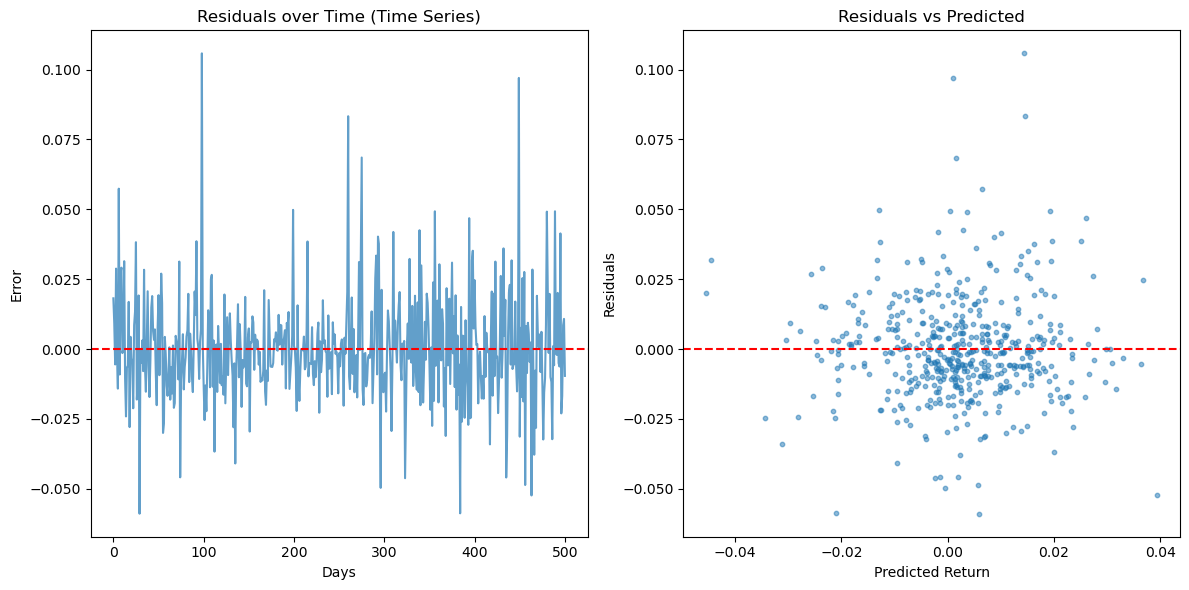

前半段殘差波動率: 0.01629
後半段殘差波動率: 0.02110
波動率變化比例: 1.30 倍


In [5]:
import matplotlib.pyplot as plt

# 1. 計算模型預測值 (Predicted Value)
# y_hat = alpha + beta * x
y_pred = alpha_manual + beta_manual * x_spy

# 2. 計算殘差 (Residuals) = 真實值 - 預測值
residuals = y_tsm - y_pred

# 3. 視覺化診斷
plt.figure(figsize=(12, 6))

# 子圖 1: 殘差的時間序列 (檢查波動率聚類)
plt.subplot(1, 2, 1)
plt.plot(residuals, alpha=0.7)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuals over Time (Time Series)")
plt.xlabel("Days")
plt.ylabel("Error")

# 子圖 2: 殘差 vs 預測值 (檢查異質變異數 Heteroscedasticity)
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.5, s=10)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Return")
plt.ylabel("Residuals")

plt.tight_layout()
plt.show()

# 4. 數據說話：殘差的波動率是否穩定？
# 我們把數據切成前後兩半，看標準差有沒有變
half = len(residuals) // 2
std_part1 = np.std(residuals[:half])
std_part2 = np.std(residuals[half:])

print(f"前半段殘差波動率: {std_part1:.5f}")
print(f"後半段殘差波動率: {std_part2:.5f}")
print(f"波動率變化比例: {std_part2 / std_part1:.2f} 倍")

In [6]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


<Figure size 1000x600 with 0 Axes>

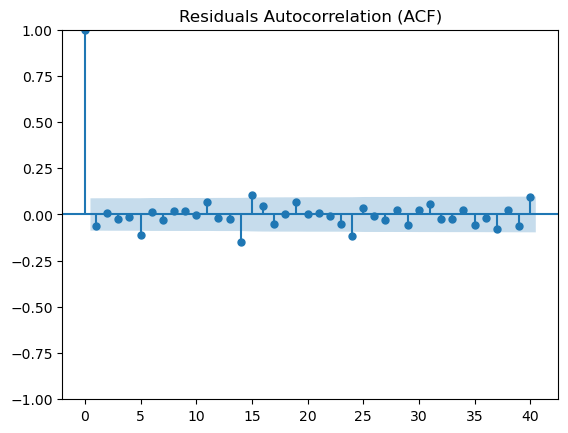

Durbin-Watson Statistic: 2.1256
結論: 殘差看起來像白雜訊 (無顯著序列相關)


In [7]:
import statsmodels.api as sm

# 1. 畫出殘差的自相關圖 (ACF Plot)
# lags=40 代表我們要看過去 40 天的殘差跟今天有沒有關係
plt.figure(figsize=(10, 6))
sm.graphics.tsa.plot_acf(residuals, lags=40, alpha=0.05)
plt.title("Residuals Autocorrelation (ACF)")
plt.show()

# 2. 進行 Durbin-Watson 檢定 (最經典的序列相關檢定)
from statsmodels.stats.stattools import durbin_watson

# DW 統計量範圍是 0 ~ 4
# 2.0 = 完全無相關 (完美)
# < 2.0 = 正相關 (今天的誤差會延續到明天)
# > 2.0 = 負相關 (今天的誤差明天會反轉)
dw_score = durbin_watson(residuals)

print(f"Durbin-Watson Statistic: {dw_score:.4f}")

if 1.8 < dw_score < 2.2:
    print("結論: 殘差看起來像白雜訊 (無顯著序列相關)")
else:
    print("結論: 殘差具有「記憶性」，模型並未完全解釋數據結構！")

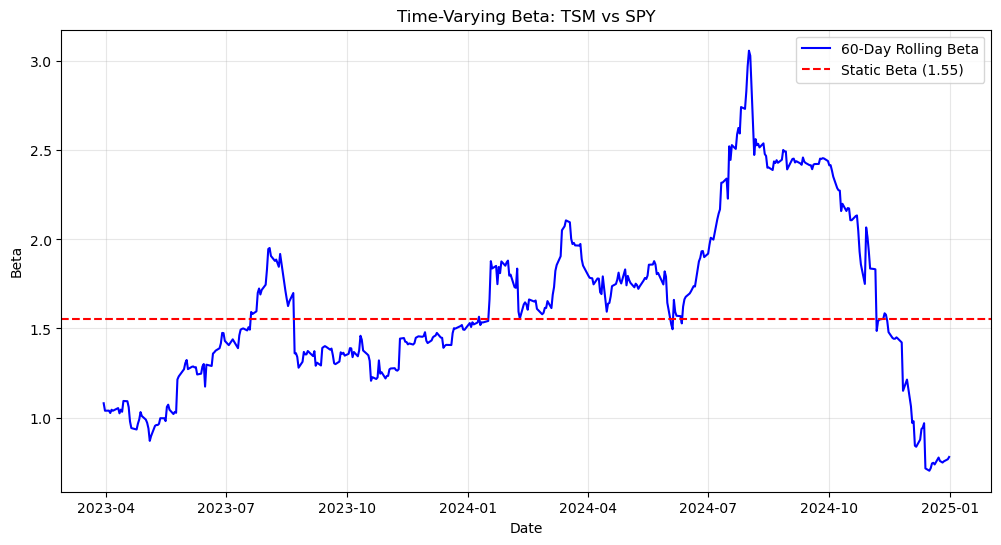

Rolling Beta Min: 0.7018
Rolling Beta Max: 3.0588
Rolling Beta Std: 0.4692


In [8]:
# 1. 設定滾動視窗 (Window)
# 我們看過去 60 個交易日 (約一季) 的關係
window_size = 60

# 2. 計算滾動共變異數 (Rolling Covariance)
# pandas 的 rolling().cov() 會回傳一個 MultiIndex，比較難處理
# 我們這裡用一個簡單的技巧：直接對 Series 操作
rolling_cov = returns['TSM'].rolling(window=window_size).cov(returns['SPY'])

# 3. 計算滾動變異數 (Rolling Variance)
rolling_var = returns['SPY'].rolling(window=window_size).var()

# 4. 計算滾動 Beta
rolling_beta = rolling_cov / rolling_var

# 5. 視覺化：靜態 vs 動態
plt.figure(figsize=(12, 6))

# 畫出動態 Beta
plt.plot(rolling_beta, label=f'{window_size}-Day Rolling Beta', color='blue')

# 畫出靜態 Beta (你剛剛手算的那個值)
plt.axhline(beta_manual, color='red', linestyle='--', label=f'Static Beta ({beta_manual:.2f})')

plt.title("Time-Varying Beta: TSM vs SPY")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylabel("Beta")
plt.xlabel("Date")
plt.show()

# 6. 統計 Beta 的變化範圍
print(f"Rolling Beta Min: {rolling_beta.min():.4f}")
print(f"Rolling Beta Max: {rolling_beta.max():.4f}")
print(f"Rolling Beta Std: {rolling_beta.std():.4f}")